In [1]:
from typing import Callable, Tuple
from qiskit import QuantumCircuit
import qiskit
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator
import math
from math import pi
import numpy as np

from sqlalchemy.orm import joinedload
from sqlalchemy import select

from benchmarklib import BenchmarkDatabase
from benchmarklib.runners import BatchQueue
from benchmarklib.pipeline.synthesis import XAGSynthesizer, TruthTableSynthesizer

from experiments import ExperimentProblem, ExperimentTrial

TAG = "adder_comparison"

In [2]:
service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer")
db = BenchmarkDatabase("experiments.db", ExperimentProblem, ExperimentTrial)

In [ ]:
#[db.delete_problem_instance(p.id) for p in db.query(select(ExperimentProblem).where(ExperimentProblem.tag == TAG))]

[None, None, None]

In [3]:
def cout1(inpt: Tuple[bool]) -> bool:
    a_and_b = inpt[0] & inpt[1]
    a_xor_b = inpt[0] ^ inpt[1]
    carry_right = a_xor_b & inpt[2]
    carry_out = a_and_b | carry_right
    return carry_out

def cout2(inpt: Tuple[bool]) -> bool:
    t1 = inpt[0] ^ inpt[1]
    t2 = (not inpt[2]) ^ inpt[1]
    t3 = t1 and t2
    carry_out = t3 ^ inpt[0]
    return carry_out


In [4]:
# build the circuits we are comparing
problems = {
    "cout1_xag": db.get_or_create(ExperimentProblem, name="cout1_xag", tag=TAG, n=3),
    "cout2_xag": db.get_or_create(ExperimentProblem, name="cout2_xag", tag=TAG, n=3),
    "cout_truth_table_synthesis": db.get_or_create(ExperimentProblem, name="cout_truth_table_synthesis", tag=TAG, n=3),
}

problems["cout1_xag"].verifier = cout1
problems["cout2_xag"].verifier = cout2
problems["cout_truth_table_synthesis"].verifier = cout1 # does not matter which one for truth table synthesis

base_circuits = {
    "cout1_xag": XAGSynthesizer().synthesize(problems["cout1_xag"]),
    "cout2_xag": XAGSynthesizer().synthesize(problems["cout2_xag"]),
    "cout_truth_table_synthesis": TruthTableSynthesizer().synthesize(problems["cout_truth_table_synthesis"]),
}
# sanity check that each circuit is equivalent
assert np.all(Operator.from_circuit(base_circuits["cout1_xag"]).data == Operator.from_circuit(base_circuits["cout2_xag"]).data)
assert np.all(Operator.from_circuit(base_circuits["cout1_xag"]).data == Operator.from_circuit(base_circuits["cout_truth_table_synthesis"]).data)

candidates = list(problems.keys())

0
1
0
1
2
0
1
2
1
0
0
1
0
1
2


In [10]:
for candidate in candidates:
    print(candidate)
    print(base_circuits[candidate].draw())
    

cout1_xag
                                   
q_0: ───────■─────────■────────────
     ┌───┐  │         │  ┌───┐     
q_1: ┤ X ├──┼────■────┼──┤ X ├─────
     └─┬─┘┌─┴─┐  │  ┌─┴─┐└─┬─┘     
q_2: ──■──┤ X ├──■──┤ X ├──■────■──
          └───┘┌─┴─┐└───┘     ┌─┴─┐
q_3: ──────────┤ X ├──────────┤ X ├
               └───┘          └───┘
cout2_xag
                                   
q_0: ───────■─────────■─────────■──
     ┌───┐  │         │  ┌───┐  │  
q_1: ┤ X ├──┼────o────┼──┤ X ├──┼──
     └─┬─┘┌─┴─┐  │  ┌─┴─┐└─┬─┘  │  
q_2: ──■──┤ X ├──■──┤ X ├──■────┼──
          └───┘┌─┴─┐└───┘     ┌─┴─┐
q_3: ──────────┤ X ├──────────┤ X ├
               └───┘          └───┘
cout_truth_table_synthesis
                    
q_0: ──o────■───────
       │    │       
q_1: ──■────┼────■──
       │    │    │  
q_2: ──┼────■────o──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘


In [6]:
def create_trials(problem: ExperimentProblem):
    trials = []
    for i in range(2**3):
        input_state = format(i, '03b')
        qc = QuantumCircuit(4, 4)
        for qubit in range(3):
            if input_state[qubit] == '1':
                qc.x(qubit)

        qc.compose(base_circuits[problem.name], inplace=True)
        qc.measure(range(4), range(4))

        qc_final = transpile(qc, backend=backend, optimization_level=3)
        trials.append(
            ExperimentTrial(
                problem=problem,
                circuit=qc_final,
                circuit_pretranspile=qc,
                extra_data={"input_state": input_state, "backend": backend.name}
            )
        )
    return trials

In [71]:
for candidate in candidates:
    problem = problems[candidate]
    trials = create_trials(problem)
    print(candidate, trials[0].circuit.depth(), trials[0].circuit.count_ops())

cout1_xag 63 OrderedDict([('rz', 53), ('sx', 34), ('ecr', 16), ('x', 4), ('measure', 4)])
cout2_xag 65 OrderedDict([('rz', 60), ('sx', 38), ('ecr', 20), ('measure', 4), ('x', 2)])
cout_truth_table_synthesis 88 OrderedDict([('rz', 71), ('sx', 40), ('ecr', 22), ('x', 6), ('measure', 4)])


In [78]:
with BatchQueue(db, backend=backend, shots=4096) as q:
    for candidate in candidates:
        problem = problems[candidate]
        # transpilation for this experiment is stochastic, so run each multiple times
        for i in range(10):
            trials = create_trials(problem)
            for trial in trials:
                q.enqueue(trial, trial.circuit, run_simulation=True)

In [7]:
await db.update_all_pending_results(service=service)

In [ ]:
trials = db.query(
    select(ExperimentTrial)
    .options(joinedload(ExperimentTrial.problem))
    .where(ExperimentTrial.problem.has(ExperimentProblem.tag == TAG))
    .where(ExperimentTrial.name == "cout1_xag")
)


### Visualize Results

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def visualize_trial_comparison(trial_names, db, TAG):
    """
    Create a comparison visualization of success rates across multiple trial types.
    
    Parameters:
    -----------
    trial_names : list of str
        List of trial type names to compare
    db : database session
        Your database session object
    TAG : str
        The experiment tag to filter by
    """
    # Collect data for all trial types
    all_trial_data = {}
    
    for trial_name in trial_names:
        # Query the trials
        trials = db.query(
            select(ExperimentTrial).join(ExperimentTrial.problem).where(
                ExperimentProblem.tag==TAG, 
                ExperimentProblem.name==trial_name
            ).options(joinedload(ExperimentTrial.problem))
        )
        
        # Collect results by input state
        results = defaultdict(list)
        output_values = {}
        for trial in trials:
            input_state = trial.extra_data["input_state"]
            success_rate = trial.calculate_success_rate()
            results[input_state].append(success_rate)
            most_likely_output = max(trial.simulation_counts, key=trial.simulation_counts.get)
            output_values[input_state] = most_likely_output[::-1]
        
        # Calculate average success rate for each input state
        avg_success_rates = {}
        for input_state, rates in results.items():
            avg_success_rates[input_state] = np.mean(rates)
        
        # Store data
        all_trial_data[trial_name] = {
            'rates': avg_success_rates,
            'overall_avg': np.mean(list(avg_success_rates.values())),
            'output_values': output_values
        }
    
    # Create the comparison plot
    num_trials = len(trial_names)
    fig, axes = plt.subplots(num_trials, 1, figsize=(12, 4 * num_trials))
    
    # Handle single trial case
    if num_trials == 1:
        axes = [axes]
    
    # Plot each trial type
    for idx, trial_name in enumerate(trial_names):
        ax = axes[idx]
        data = all_trial_data[trial_name]
        
        # Create 2x4 grid data
        grid_data = np.zeros((2, 4))
        for i in range(8):
            input_state = f"{i:03b}"
            row = i // 4
            col = i % 4
            grid_data[row, col] = data['rates'].get(input_state, 0)
        
        # Create heatmap
        im = ax.imshow(grid_data, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
        
        # Set ticks and labels
        ax.set_xticks(np.arange(4))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        # Add input state labels and success rates in each cell
        for i in range(8):
            row = i // 4
            col = i % 4
            input_state = f"{i:03b}"
            output_state = data['output_values'].get(input_state[:3], '-')[-1]
            success_rate = data['rates'].get(input_state, 0)
            
            # Input state label (top)
            ax.text(col, row - 0.25, f"|{input_state}⟩ → {output_state}", 
                    ha="center", va="center", color="black", fontsize=11, fontweight='bold')
            
            # Success rate (bottom)
            color = "white" if success_rate < 0.1 else "black"
            ax.text(col, row + 0.25, f"{success_rate:.1%}", 
                    ha="center", va="center", color=color, fontsize=13, fontweight='bold')
        
        # Set title with overall average
        ax.set_title(f'{trial_name} (Overall Avg: {data["overall_avg"]:.2%})', 
                     fontsize=13, fontweight='bold', pad=15)
        
        # Remove tick marks
        ax.tick_params(length=0)
        
        # Add grid
        ax.set_xticks(np.arange(4) - 0.5, minor=True)
        ax.set_yticks(np.arange(2) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)
    
    # Add horizontal colorbar at the bottom
    fig.subplots_adjust(bottom=0.12)
    cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Success Rate', fontsize=12)
    
    plt.suptitle('Adder Cout Implementation Comparison', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.96])
    return fig, axes


/tmp/ipykernel_3564/4015930018.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.96])


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: title={'center': 'cout1_xag (Overall Avg: 57.88%)'}>,
        <Axes: title={'center': 'cout2_xag (Overall Avg: 67.59%)'}>,
        <Axes: title={'center': 'cout_truth_table_synthesis (Overall Avg: 42.54%)'}>],
       dtype=object))

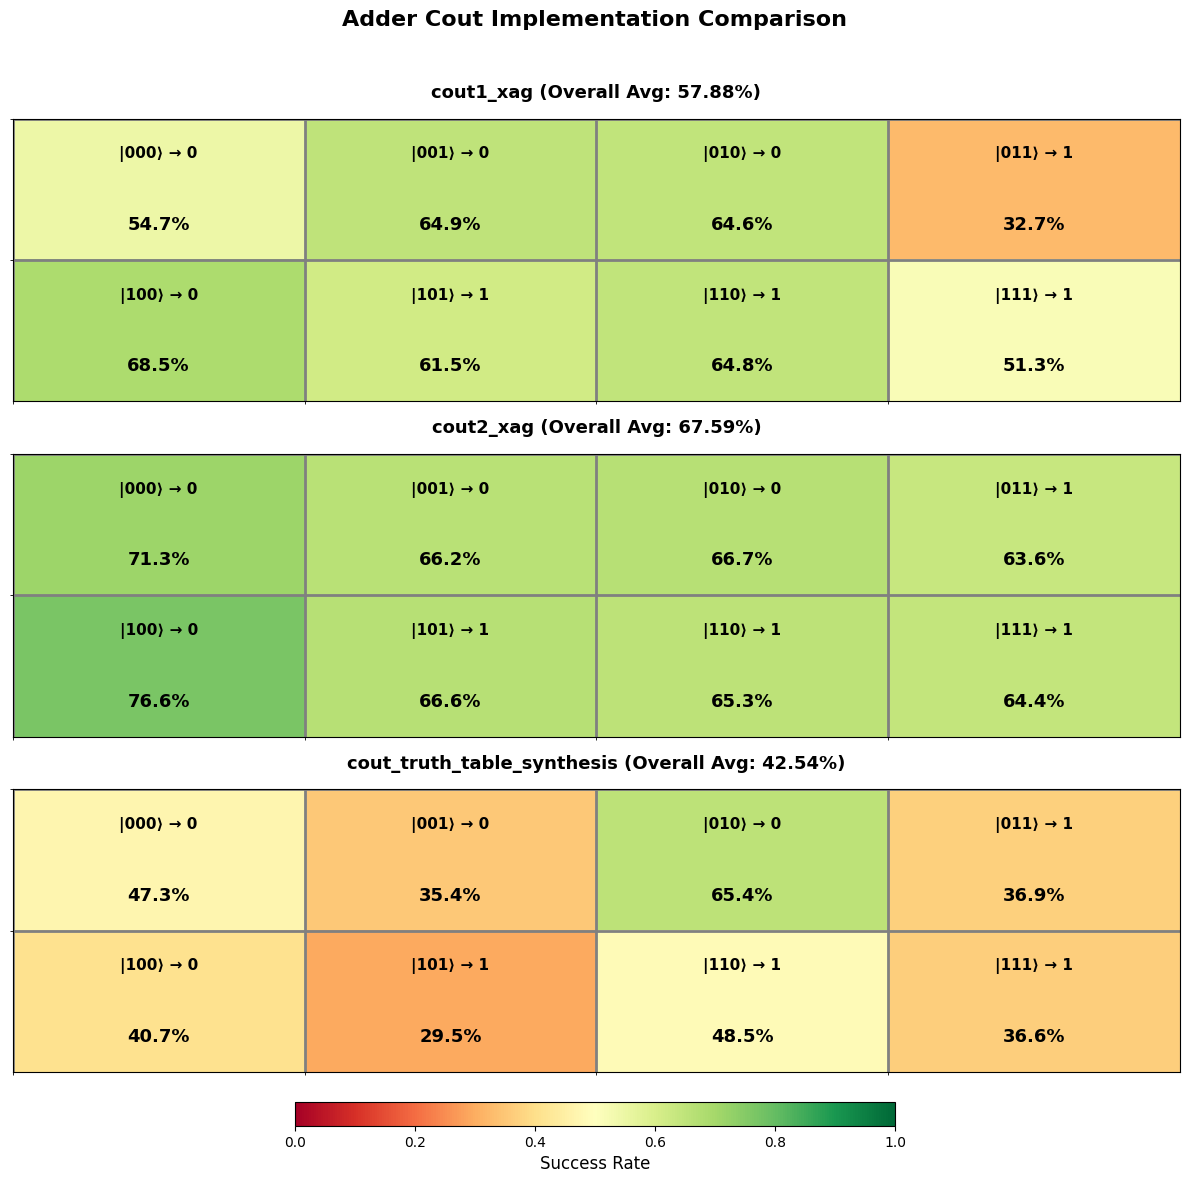

In [9]:
visualize_trial_comparison(
    ["cout1_xag", "cout2_xag", "cout_truth_table_synthesis"], 
    db, 
    TAG
)

### Compare Measurement PST with Noisy Simulator PST

In [ ]:
noisy_simulator = AerSimulator.from_backend(backend)
print("Experimental Fraction Correct, Noisy Simulator Fraction Correct")
for trial in db.query(select(ExperimentTrial).join(ExperimentTrial.problem).where(ExperimentProblem.tag == TAG)).options(joinedload(ExperimentTrial.problem)):
    correct_result = max(trial.simulation_counts, key=trial.simulation_counts.get)  # pure state output, so there is just one correct result
    experimental_fraction_correct = trial.experimental_counts.get(correct_result, 0) / sum(trial.experimental_counts.values())

    noisy_result = noisy_simulator.run(trial.circuit, shots=4096).result()
    noisy_counts = noisy_result.get_counts()
    noisy_fraction_correct = noisy_counts.get(correct_result, 0) / sum(noisy_counts.values())

    print(experimental_fraction_correct, noisy_fraction_correct)


In [12]:
from collections import defaultdict


noisy_simulator = AerSimulator.from_backend(backend)
simulation_pst = defaultdict(list)
for trial in db.query(select(ExperimentTrial).join(ExperimentTrial.problem).where(ExperimentProblem.tag == TAG).options(joinedload(ExperimentTrial.problem))):
    correct_result = max(trial.simulation_counts, key=trial.simulation_counts.get)  # pure state output, so there is just one correct result

    noisy_result = noisy_simulator.run(trial.circuit, shots=4096).result()
    noisy_counts = noisy_result.get_counts()
    noisy_fraction_correct = noisy_counts.get(correct_result, 0) / sum(noisy_counts.values())

    simulation_pst[trial.problem.name].append(noisy_fraction_correct)



In [13]:
for candidate in candidates:
    results = simulation_pst[candidate]
    mean = sum(results) / len(results)
    variance = sum((x - mean) ** 2 for x in results) / len(results)
    stddev = math.sqrt(variance)
    print(f"{candidate}: Mean PST={mean:.4f}, StdDev={stddev:.4f}")

cout1_xag: Mean PST=0.9112, StdDev=0.0084
cout2_xag: Mean PST=0.9165, StdDev=0.0082
cout_truth_table_synthesis: Mean PST=0.8825, StdDev=0.0091
